In [60]:
import numpy as np
import h5py
import os
import pandas as pd

In [61]:
%pylab inline
import matplotlib.pyplot as plt
import seaborn
seaborn.set()

Populating the interactive namespace from numpy and matplotlib


In [62]:
resultsdir = '../results/cartpole_ddpg_stable'

In [64]:
sorted(os.listdir(resultsdir))

['lrq1e-1_momentum0.2_nesterov',
 'lrq1e-1_momentum0.2_nesterov_alpha2',
 'normal',
 'normal_lrq10',
 'normal_lrq10_2',
 'normal_lrq10_no_beta',
 'normal_lrq10_single_env',
 'normal_lrq10_wout_norminp',
 'normal_lrq10_wout_time',
 'normal_lrq1e_2_rms_prop',
 'normal_lrq20',
 'normal_lrq2e_1_opt_q_layerwise_kernel',
 'prioritized_lrq10',
 'prioritized_v2_no_batchnorm_unstable']

In [65]:
savedirs = {k: os.path.join(resultsdir,k) for k in os.listdir(resultsdir)}

In [66]:
def loadHDF5(filepath):
    output = {}
    with h5py.File(filepath,'r') as f:
        for k in f:
            output[k] = np.array(f[k])
    return output

In [67]:
results = {}
for sd in sorted(savedirs):
    results[sd] = {}
    data = []
    for rd in os.listdir(savedirs[sd]):
        filepath = os.path.join(savedirs[sd],rd,'log.h5')
        
        if os.path.exists(filepath):
            data.append(loadHDF5(filepath))
        else:
            print('path does not exist',filepath)

    if len(data) > 0:
        keys = data[0].keys()
        for k in keys:
            V = [v[k] for v in data]
            if len(V[0].shape) == 1:
                results[sd][k] = np.stack(V)
            else:
                results[sd][k] = np.concatenate(V,axis=-1).T
            print(sd,k,results[sd][k].shape,V[0].shape)
    if len(results[sd]) == 0:
        results.pop(sd)

path does not exist ../results/cartpole_ddpg_stable/lrq1e-1_momentum0.2_nesterov/experiment-5187885518866329582/log.h5
lrq1e-1_momentum0.2_nesterov Q (9, 9900) (9900,)
lrq1e-1_momentum0.2_nesterov action_history (90, 10000) (10000, 10)
lrq1e-1_momentum0.2_nesterov beta (9, 0) (0,)
lrq1e-1_momentum0.2_nesterov duration_cumulative (9, 10000) (10000,)
lrq1e-1_momentum0.2_nesterov max_importance_weight (9, 0) (0,)
lrq1e-1_momentum0.2_nesterov reward_history (90, 10000) (10000, 10)
lrq1e-1_momentum0.2_nesterov step_duration_sec (9, 10000) (10000,)
lrq1e-1_momentum0.2_nesterov test_ep_returns (90, 99) (99, 10)
lrq1e-1_momentum0.2_nesterov test_ep_steps (9, 99) (99,)
lrq1e-1_momentum0.2_nesterov_alpha2 Q (10, 9900) (9900,)
lrq1e-1_momentum0.2_nesterov_alpha2 action_history (100, 10000) (10000, 10)
lrq1e-1_momentum0.2_nesterov_alpha2 beta (10, 0) (0,)
lrq1e-1_momentum0.2_nesterov_alpha2 duration_cumulative (10, 10000) (10000,)
lrq1e-1_momentum0.2_nesterov_alpha2 max_importance_weight (10, 0) (

In [68]:
for sd in sorted(results):
    print(sd,results[sd]['test_ep_returns'].shape)

lrq1e-1_momentum0.2_nesterov (90, 99)
lrq1e-1_momentum0.2_nesterov_alpha2 (100, 99)
normal (100, 99)
normal_lrq10 (100, 99)
normal_lrq10_2 (100, 99)
normal_lrq10_no_beta (90, 99)
normal_lrq10_single_env (10, 99)
normal_lrq10_wout_norminp (70, 99)
normal_lrq10_wout_time (100, 99)
normal_lrq1e_2_rms_prop (50, 99)
normal_lrq20 (100, 99)
prioritized_lrq10 (90, 99)
prioritized_v2_no_batchnorm_unstable (100, 99)


In [69]:
def smooth(x,k=10.):
    return np.convolve(x,np.ones(int(k))*1./k)

In [70]:
def plot_percentiles(x,y=None,label=None,smoothing=False):
    if y is None:
        y = x
        x = np.arange(len(y))
    p10 = np.percentile(y,10,axis=1)
    mean = y.mean(axis=1)
    p90 = np.percentile(y,90,axis=1)
    
    if smoothing:
        f = lambda y: smooth(y)
        p10 = f(p10)
        mean = f(mean)
        p90 = f(p90)
        x = np.arange(len(mean))
        
    plt.fill_between(x,p10,p90,alpha=0.25)
    plt.plot(x,mean,label=label)

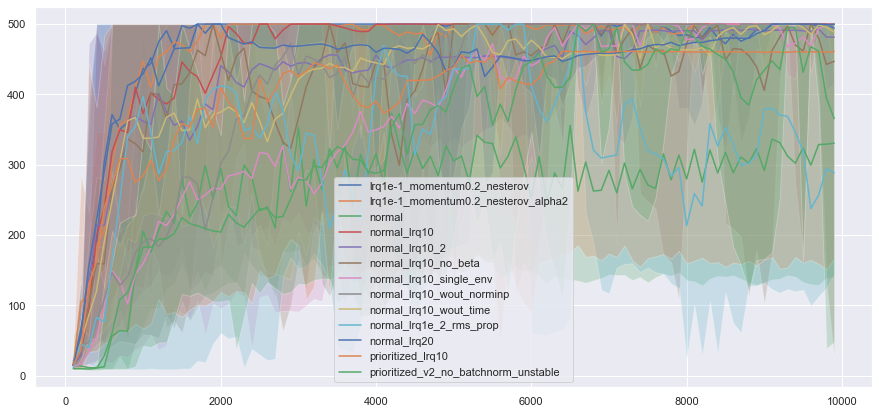

In [71]:
key = 'test_ep_returns'
plt.figure(figsize=(15,7))
for sd in results:
    plot_percentiles(results[sd]['test_ep_steps'][0],results[sd][key].T,label=sd)
_ = plt.legend()

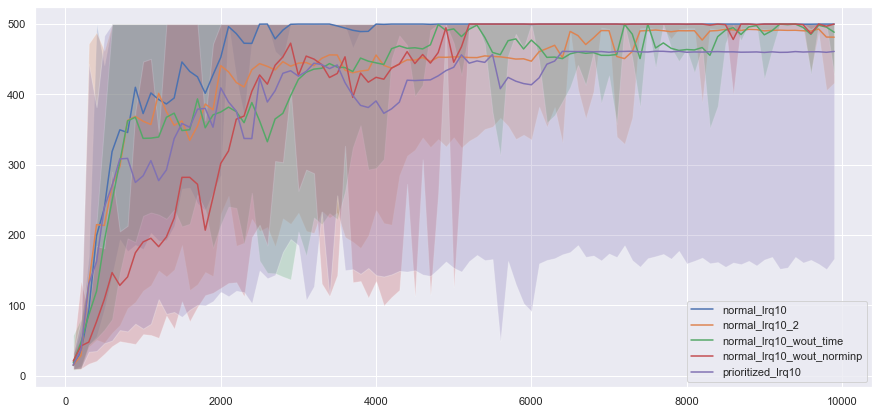

In [72]:
key = 'test_ep_returns'
plt.figure(figsize=(15,7))
for sd in ['normal_lrq10','normal_lrq10_2','normal_lrq10_wout_time','normal_lrq10_wout_norminp','prioritized_lrq10']:
    plot_percentiles(results[sd]['test_ep_steps'][0],results[sd][key].T,label=sd)
_ = plt.legend()

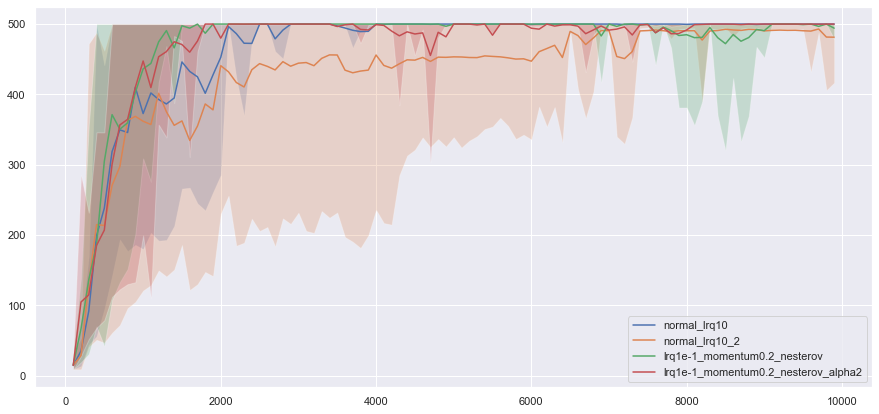

In [74]:
key = 'test_ep_returns'
plt.figure(figsize=(15,7))
for sd in ['normal_lrq10',
           'normal_lrq10_2',
           'lrq1e-1_momentum0.2_nesterov',
           'lrq1e-1_momentum0.2_nesterov_alpha2']:
    plot_percentiles(results[sd]['test_ep_steps'][0],results[sd][key].T,label=sd)
_ = plt.legend()

(10, 10, 99)

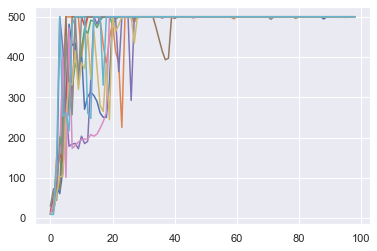

In [58]:
a = []
for i in range(0,100,10):
    b = results['normal_lrq10']['test_ep_returns'][i:i+10]
    plt.plot(b.mean(axis=0))
    a.append(b)
a = np.stack(a)
a.shape

/Users/justinmaojones/rl/env/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice.
  after removing the cwd from sys.path.


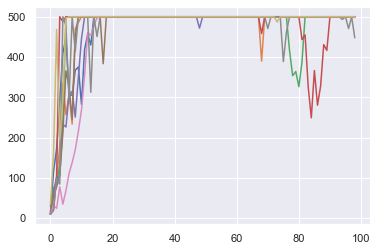

In [59]:
a = []
for i in range(0,100,10):
    b = results['lrq1e-1_momentum0.2_nesterov']['test_ep_returns'][i:i+10]
    plt.plot(b.mean(axis=0))
    a.append(b)
#a = np.stack(a)
#a.shape

(10, 10, 99)

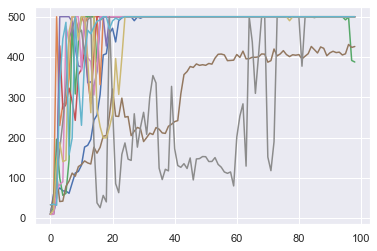

In [61]:
a = []
for i in range(0,100,10):
    b = results['normal_lrq10_2']['test_ep_returns'][i:i+10]
    plt.plot(b.mean(axis=0))
    a.append(b)
a = np.stack(a)
a.shape

(9, 10, 99)

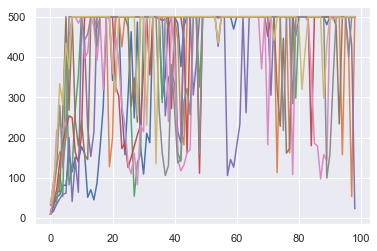

In [64]:
a = []
for i in range(0,90,10):
    b = results['normal_lrq10_no_beta']['test_ep_returns'][i:i+10]
    plt.plot(b.mean(axis=0))
    a.append(b)
a = np.stack(a)
a.shape

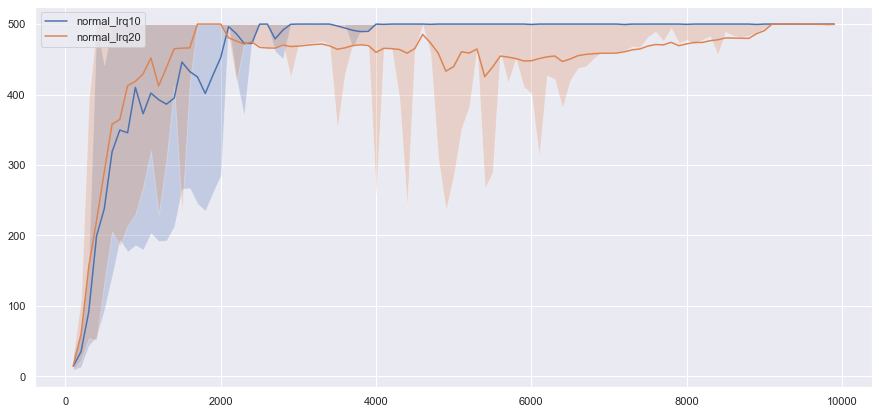

In [56]:
key = 'test_ep_returns'
plt.figure(figsize=(15,7))
for sd in ['normal_lrq10','normal_lrq20']:
    plot_percentiles(results[sd]['test_ep_steps'][0],results[sd][key].T,label=sd)
_ = plt.legend()

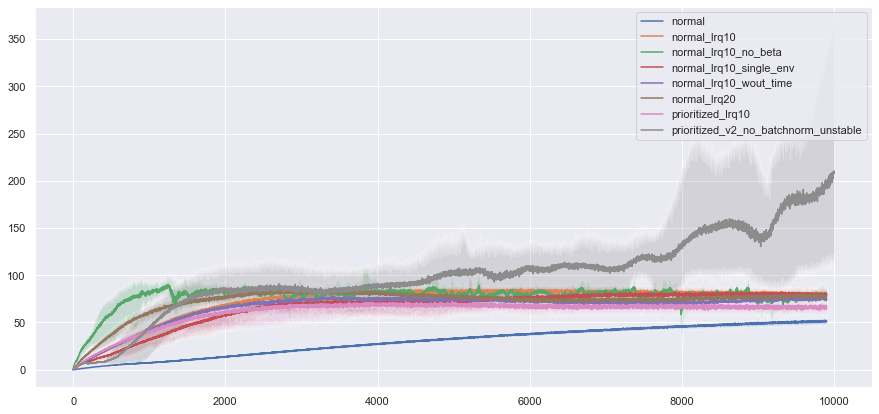

In [26]:
key = 'Q'
plt.figure(figsize=(15,7))
for sd in results:
    plot_percentiles(results[sd][key].T,label=sd)
_ = plt.legend()

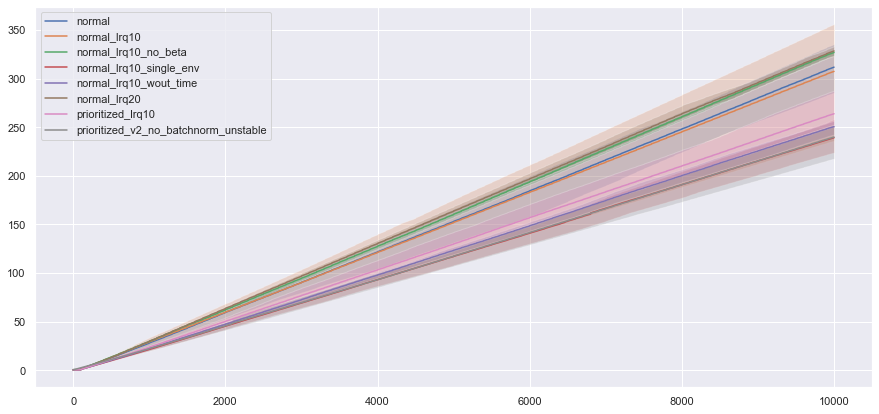

In [27]:
key = 'duration_cumulative'
plt.figure(figsize=(15,7))
for sd in results:
    plot_percentiles(results[sd][key].T,label=sd)
_ = plt.legend()

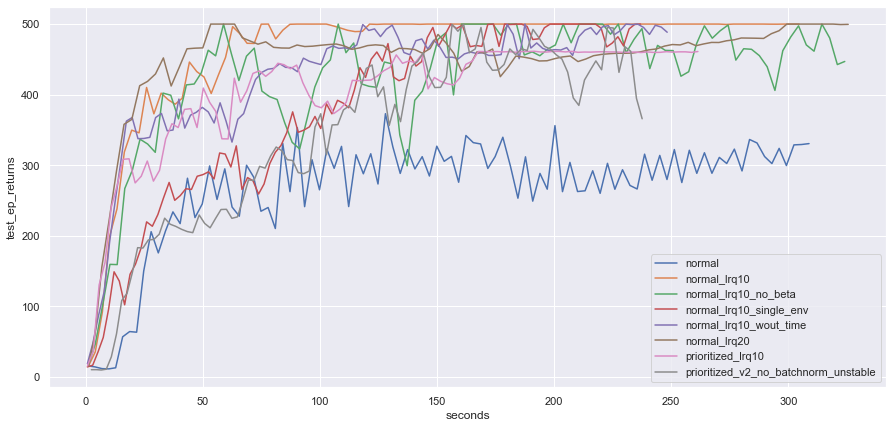

In [28]:
plt.figure(figsize=(15,7))
for sd in results:
    plt.plot(
        results[sd]['duration_cumulative'][:,results[sd]['test_ep_steps'][0]].mean(axis=0),
        results[sd]['test_ep_returns'].mean(axis=0),
        label=sd
    )
plt.xlabel('seconds')
plt.ylabel('test_ep_returns')
_ = plt.legend()